<a href="https://colab.research.google.com/github/aditijantikar/In-Silico-Toxicology-Modelling/blob/main/In_Silico_Toxicology_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extra Implementation:

To build upon the baseline model, I implemented a LightGBM classifier for the mitochondrial toxicity prediction task. LightGBM is a high-performance gradient boosting framework known for its speed and accuracy, often outperforming traditional algorithms like Random Forest.

The goal of this extension was to:

* Compare algorithms: Evaluate if a modern gradient boosting model could achieve a higher predictive accuracy than the baseline.

* Demonstrate proficiency: Showcase experience with industry-standard tools beyond the Scikit-learn library.

By training the LGBMClassifier on the same dataset, I could directly compare its AUC-ROC and balanced accuracy scores against the original Random Forest model to determine the more effective approach for this specific problem.

In [1]:
%pip install rdkit seaborn shap
!wget https://raw.githubusercontent.com/Hitchhikers-AI-Guide/AIGuideToDrugDiscovery/main/data/tox_prediction/hERG_IC50.csv
!wget https://raw.githubusercontent.com/Hitchhikers-AI-Guide/AIGuideToDrugDiscovery/main/data/tox_prediction/Mitotox_Dataset_Classification_Workshop.csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 34.2 MB/s eta 0:00:00
--2025-10-05 20:28:19--  https://raw.githubusercontent.com/Hitchhikers-AI-Guide/AIGuideToDrugDiscovery/main/data/tox_prediction/hERG_IC50.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6289644 (6.0M) [text/plain]
Saving to: ‘hERG_IC50.csv’

hERG_IC50.csv       100%[===================>]   6.00M  --.-KB/s    in 0.09s   

2025-10-05 20:28:19 (70.0 MB/s) - ‘hERG_IC50.csv’ saved [6289644/6289644]

--2025-10-05 20:28:20--  https://raw.githubusercontent.com/Hitchhikers-AI-Guide/AIGuideToDrugDiscovery/main/data/tox_prediction/Mitotox_Dataset_Classification_Workshop.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.13

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np

## Regression modelling hERG IC50

Here, we will use Random Forests to model hERG inhibition (in the form of IC50 data).

### Data Cleaning

Loading and cleaning the dataset.

First, we will read in the data file hERG_IC50.csv. This contains IC50 bioactivity data for the hERG protein target, extracted from [ChEMBL](https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/target_chembl_id%3ACHEMBL240)

In [4]:
herg_data = pd.read_csv("hERG_IC50.csv")
herg_data.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3121096,NaN,0,339.44,0.0,2.55,"S,R(-)-4b, (1S,6R(-)-4b), S,R-4b",O=C1NN=C(c2ccc(OC3CCN(C4CCC4)CC3)cc2)[C@@H]2C[...,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL3120141,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,NaN,NaN
1,CHEMBL23,DILTIAZEM,4,414.53,0.0,3.37,Diltiazem,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1135758,1,Scientific Literature,J. Med. Chem.,2002.0,NaN,NaN
2,CHEMBL556247,NaN,0,408.42,0.0,2.77,6,CN1C[C@H]2[C@@H](C1)[C@@H]2CN(Cc1cccc(OC(F)(F)...,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1158414,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2009.0,CHEMBL3307715,NaN
3,CHEMBL216959,NaN,0,499.65,0.0,2.30,4g,O=C1CN(CCc2ccc(F)cc2)CCN1[C@H]1CCc2cc(CN3CCS(=...,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1137586,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2007.0,NaN,NaN
4,CHEMBL214969,NaN,0,338.34,0.0,2.68,8c,COc1ccc2c(=O)n(CCO)c(C#N)c(-c3cccc(F)c3)c2c1,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1137352,1,Scientific Literature,J. Med. Chem.,2006.0,NaN,NaN


 All we need for modelling is the SMILES, standard relation and pChEMBL value (-log10[molar IC50]). Subsetting the dataframe to only contain these columns.

In [5]:
herg_data_dropped = herg_data[['Smiles','Standard Relation','pChEMBL Value']]
herg_data_dropped.head()

,Smiles,Standard Relation,pChEMBL Value
0,O=C1NN=C(c2ccc(OC3CCN(C4CCC4)CC3)cc2)[C@@H]2C[...,'=',5.22
1,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,'=',4.76
2,CN1C[C@H]2[C@@H](C1)[C@@H]2CN(Cc1cccc(OC(F)(F)...,'=',5.42
3,O=C1CN(CCc2ccc(F)cc2)CCN1[C@H]1CCc2cc(CN3CCS(=...,'=',4.62
4,COc1ccc2c(=O)n(CCO)c(C#N)c(-c3cccc(F)c3)c2c1,'=',4.21


In [6]:
herg_data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14364 entries, 0 to 14363
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Smiles             14332 non-null  object 
 1   Standard Relation  12542 non-null  object 
 2   pChEMBL Value      8744 non-null   float64
dtypes: float64(1), object(2)
memory usage: 336.8+ KB


The initial dataset of 14,364 entries contains missing values in key columns. A breakdown of non-null entries includes:


*   14,332 entries have non-null SMILES
*   12,542 entries have non-null Standard Relations
*   8,744 entries have non-null pChEMBL Values

For machine learning, we need a complete dataset with no missing values. To create this, we will use the pandas dropna(how='any') function. This function removes any row containing at least one null value, ensuring the final DataFrame is fully populated for model training.

In [7]:
herg_data_dropna = herg_data_dropped.dropna(how='any')
print(herg_data_dropna.shape)

(8744, 3)


After dropping null values, we are left with 8,744 rows.

Next, we only want to include the data for modelling if the Standard Relation is '='.

We can check which Standard Relation symbols are in our DataFrame using `unique` to extract only the unique items in the column.

In [8]:
std_relations = herg_data_dropna['Standard Relation'].unique()
print(std_relations)


["'='"]


No data cleaning needed here. The final important thing we need to deal with is duplicate values.

To find how many duplicates we have per compound, we can use the Pandas `groupby` function to group the DataFrame in terms of the 'Smiles' column,`size` to count the number of entries, then finally `sort_values `in descending order.



In [9]:
herg_data_dropna.groupby(['Smiles']).size().sort_values(ascending=False)

,0
Smiles,
CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1,24
COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC,21
Cc1nc2n(c(=O)c1CCN1CCC(c3noc4cc(F)ccc34)CC1)CCCC2,20
COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,20
CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=O)cc1,19
...,...
c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2)c[nH]1)C3,1
c1ccc2c3c([nH]c2c1)[C@@H](C1CCOCC1)N[C@@H](c1nc(-c2ccncc2)c[nH]1)C3,1
c1ccc2c3c([nH]c2c1)[C@@H](C1CCOCC1)N[C@@H](c1nc(-c2ccsc2)c[nH]1)C3,1


The compound with the SMILES C(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1 is present in the dataset 24 times. The length of the output is 7,412, meaning that there are 7,412 unique SMILES structures in the dataset.

To deal with duplicates, we can again `groupby` SMILES, and this time take the `mean` of the PChEMBL values from the grouped DataFrame.

In [10]:
# we include 'Standard Relation' in the grouping to keep the column
herg_data_cleaned = herg_data_dropna.groupby(['Smiles','Standard Relation'])['pChEMBL Value'].mean()

# turn it back into DataFrame format
herg_data_cleaned = pd.DataFrame(herg_data_cleaned)
herg_data_cleaned.head()

,,pChEMBL Value
Smiles,Standard Relation,
Br.CN(C)c1ccc(/N=N/c2ccccn2)c(O)c1,'=',6.62
Brc1ccc(Nc2ccc(CN3CCC4(CC3)OCCc3sccc34)cc2)cc1,'=',5.37
Brc1ccc2c(NC3=NC[C@@]4(CN5CCC4CC5)O3)ncnn12,'=',5.60
Brc1cccc2nc(C#Cc3ccccn3)ccc12,'=',4.64
Brc1cnc2nc(N3CCN4CCC3CC4)oc2c1,'=',5.64


Because we used the "Smiles" and "Standard Relation" columns for the grouping, these have become indexes in the DataFrame. With reset_index we can change these back to normal columns

In [11]:
herg_data_cleaned = herg_data_cleaned.reset_index()
herg_data_cleaned.shape

(7412, 3)

Now we have a non-duplicated dataset of 7,412 unique compounds.

Note that there are other ways to deal with duplicates, for example by discarding outliers before taking the mean, or by taking the median.

Let's see what the distribution of pChEMBL values looks like. We can achieve this using the `violinplot` function in Seaborn. We just need to pass the DataFrame column to the function like so:

<Axes: xlabel='pChEMBL Value'>

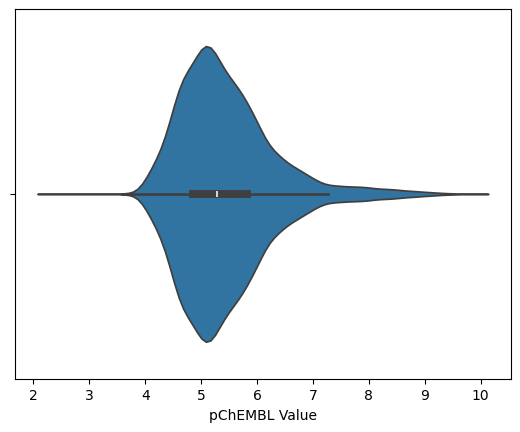

In [14]:
sns.violinplot(x=herg_data_cleaned["pChEMBL Value"])

From this plot, we can see that most of the pChEMBL values fall around ~5 and span from ~2 to ~10.

We can also use the `describe` function to summarise the pChEMBL value distribution:

In [15]:
herg_data_cleaned.describe()

,pChEMBL Value
count,7412.000000
mean,5.435863
std,0.859740
min,2.360000
25%,4.850000
50%,5.280000
75%,5.820000
max,9.850000


### Featurisation

Now that the data is clean, we can generate our features.

In this exercise, we will use the RDKit descriptors to featurise our compounds. The following code assigns a list of available descriptors to the variable 'descriptor_names' and prints the length of the list.

In [16]:
from rdkit.Chem import Descriptors

# get list of all available Descriptors
descriptors_list = [x[0] for x in Descriptors._descList]
print(len(descriptors_list))

217


Let's take a selection of descriptors and use them for modelling. For this exercise we will use a subset of 78 descriptors used in this NCATS article https://pubs.acs.org/doi/10.1021/acs.jcim.0c00884


In [17]:
chosen_descriptors = [
    "MolLogP", "MolWt", "TPSA", "LabuteASA", "HeavyAtomMolWt", "ExactMolWt",
    "NumHAcceptors", "NumHDonors", "NumRotatableBonds", "NumHeteroatoms",
    "HeavyAtomCount", "NHOHCount", "NOCount", "NumAliphaticCarbocycles",
    "NumAliphaticHeterocycles", "NumAliphaticRings", "NumAromaticCarbocycles",
    "NumAromaticHeterocycles", "NumAromaticRings", "NumSaturatedCarbocycles",
    "NumSaturatedHeterocycles", "NumSaturatedRings", "RingCount",
    "FractionCSP3", "Chi0v", "Chi1v", "Chi2v", "Chi3v", "Chi4v", "Chi1n",
    "Chi2n", "Chi3n", "Chi4n", "HallKierAlpha", "Kappa1", "Kappa2", "Kappa3",
    "SlogP_VSA1", "SlogP_VSA2", "SlogP_VSA3", "SlogP_VSA4", "SlogP_VSA5",
    "SlogP_VSA6", "SlogP_VSA7", "SlogP_VSA8", "SlogP_VSA9", "SlogP_VSA10",
    "SlogP_VSA11", "SlogP_VSA12", "SMR_VSA1", "SMR_VSA2", "SMR_VSA3", "SMR_VSA4",
    "SMR_VSA5", "SMR_VSA6", "SMR_VSA7", "SMR_VSA8", "SMR_VSA9", "SMR_VSA10",
    "PEOE_VSA1", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA4", "PEOE_VSA5", "PEOE_VSA6",
    "PEOE_VSA7", "PEOE_VSA8", "PEOE_VSA9", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12",
    "PEOE_VSA13", "PEOE_VSA14"
]

Next, we need to set up a calculator to calculate the descriptors. The ML.Descriptors module has a MolecularDescriptorsCalculator to achieve this.

In [18]:
from rdkit.ML.Descriptors import MoleculeDescriptors
calc = MoleculeDescriptors.MolecularDescriptorCalculator(chosen_descriptors)

Once the calc variable is set up, we can calculate all descriptors for a given SMILES string like so:

In [19]:
from rdkit import Chem
mol = Chem.MolFromSmiles('CC1=CC(=C(C=C1NC(=O)C2=C(C(=CC(=C2)I)I)O)Cl)C(C#N)C3=CC=C(C=C3)Cl')
ds = calc.CalcDescriptors(mol)
print(ds)
print(len(ds))

(7.124400000000003, 663.0799999999998, 73.12, 211.0337664023786, 648.9679999999996, 661.852179048, 3, 2, 4, 8, 30, 2, 4, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0.09090909090909091, 21.337540270596875, 11.567487609533984, 9.791667981874944, 6.532560560468579, 5.210790706092031, 8.654060372339206, 6.540209173088069, 4.508130316967467, 2.9673141998441293, -1.5399999999999987, 23.130028268670063, 9.726157452179187, 5.018674352279847, 5.316788604006331, 11.013707124192212, 0.0, 25.395214609352177, 32.9662491970212, 48.53093654769288, 10.045266627482652, 0.0, 0.0, 5.687386274683562, 5.749511833283905, 68.38362103460115, 9.901064578912528, 5.261891554738487, 0.0, 0.0, 12.841643245852017, 5.316788604006331, 87.97037368409433, 0.0, 11.818733146076179, 79.97818703863621, 10.423315998847038, 4.794537184071822, 0.0, 5.261891554738487, 0.0, 41.40098098584986, 99.12766827122579, 19.30283517323161, 21.120761121716058, 5.749511833283905, 0.0, 0.0, 5.907179729351506, 0.0)
73


Let's iterate over each SMILES string in our dataset and return the descriptors. We will use paralellisation to speed this up

In [20]:
def descriptors_from_smiles(smi):
  mol = Chem.MolFromSmiles(smi)
  desc = calc.CalcDescriptors(mol)
  return list(desc)

from joblib import Parallel, delayed
all_smiles = herg_data_cleaned['Smiles'].tolist()
all_descriptors = Parallel(n_jobs=-1, prefer='threads')(delayed(descriptors_from_smiles)(smi) for smi in all_smiles)

Now we want the descriptors in the format of a DataFrame for Machine Learning, where each row is a data point (compound) and each column is a descriptor. To do this, we just call pd.DataFrame on the list of calculated descriptors, and each item in the list will be transformed into a row of the DataFrame.

In [21]:
desc_df = pd.DataFrame(all_descriptors)
desc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,3.8465,323.194,61.08,121.951577,308.074,322.042923,5,1,3,6,...,27.209951,6.066367,24.265468,32.045941,0.000000,11.436898,5.817863,0.000000,0.000000,0.0
1,6.3182,469.448,24.50,184.384618,444.248,468.087097,4,1,4,5,...,11.336786,28.062678,71.813178,46.779730,12.207933,0.000000,0.000000,0.000000,0.000000,0.0
2,1.7543,377.246,67.05,141.410410,360.110,376.064721,7,1,1,8,...,0.000000,0.000000,53.993834,12.462662,6.544756,22.048268,5.817863,0.000000,6.021680,0.0
3,3.7921,309.166,25.78,119.206115,300.094,307.994910,2,0,0,3,...,0.000000,28.062678,48.239071,16.055787,5.516701,11.387856,0.000000,0.000000,0.000000,0.0
4,2.2697,323.194,45.40,119.276840,308.074,322.042923,5,0,1,6,...,0.000000,0.000000,28.771587,48.956797,0.000000,0.000000,5.583020,5.647177,6.014659,0.0


To understand feature importance later, we need to set the DataFrame column names to correspond to each descriptor. Since we already have the descriptor names stored in a list, we assign the .columns attribute of the DataFrame to the list.

In [22]:
desc_df.columns = chosen_descriptors
desc_df.head()

,MolLogP,MolWt,TPSA,LabuteASA,HeavyAtomMolWt,ExactMolWt,NumHAcceptors,NumHDonors,NumRotatableBonds,NumHeteroatoms,...,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14
0,3.8465,323.194,61.08,121.951577,308.074,322.042923,5,1,3,6,...,27.209951,6.066367,24.265468,32.045941,0.000000,11.436898,5.817863,0.000000,0.000000,0.0
1,6.3182,469.448,24.50,184.384618,444.248,468.087097,4,1,4,5,...,11.336786,28.062678,71.813178,46.779730,12.207933,0.000000,0.000000,0.000000,0.000000,0.0
2,1.7543,377.246,67.05,141.410410,360.110,376.064721,7,1,1,8,...,0.000000,0.000000,53.993834,12.462662,6.544756,22.048268,5.817863,0.000000,6.021680,0.0
3,3.7921,309.166,25.78,119.206115,300.094,307.994910,2,0,0,3,...,0.000000,28.062678,48.239071,16.055787,5.516701,11.387856,0.000000,0.000000,0.000000,0.0
4,2.2697,323.194,45.40,119.276840,308.074,322.042923,5,0,1,6,...,0.000000,0.000000,28.771587,48.956797,0.000000,0.000000,5.583020,5.647177,6.014659,0.0


Now we have our features in the correct format for modelling!

When calculating descriptors its possible that some calculations will fail, resulting in null values for some compound-descriptor combinations. To remove columns where there are null values present in any row, we can use dropna again. This time, we pass axis=1 to indicate that we want to drop columns, not rows.

In [23]:
desc_df = desc_df.dropna(axis=1,how='any')
desc_df.shape

(7412, 73)

0 descriptors were dropped due to null values.

### Model training

Now we have cleaned the data and calculated our descriptors, we can proceed with modelling.

Let's start with performing a train-test split. We first need our pChEMBL values in the form of a 1D array.

In [24]:
pchembl_array = np.ravel(herg_data_cleaned['pChEMBL Value'].values)
pchembl_array

array([6.62, 5.37, 5.6 , ..., 4.92, 5.19, 4.63])

Now we can use `train_test_split` to define our X_train, y_train, X_test and y_test. Let's use an 80:20 split.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(desc_df, pchembl_array, test_size=0.2, random_state=42)

Now we have split the data, we can train a Random Forest Regressor. Warning: This takes a moment to run!

In [26]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_jobs=-1)
reg.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1)

Next, we apply the model to the test dataset descriptors (X_test) and store the results in a variable called y_pred.

In [27]:
y_pred = reg.predict(X_test)
y_pred

array([5.86325   , 5.11466   , 5.27074   , ..., 5.02948333, 5.32012476,
       4.7961    ])

How well has our model performed? Let's calculate the r2 and mean absolute error

In [28]:
from sklearn.metrics import r2_score, mean_absolute_error
r2 = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)

print(r2)
print(mae)

0.49097913234687507
0.4534081404051682


The model has an r2 score of 0.50 and a mean absolute error of 0.45. Let's visualise the true vs the predicted values.

<Axes: xlabel='True', ylabel='Predicted'>

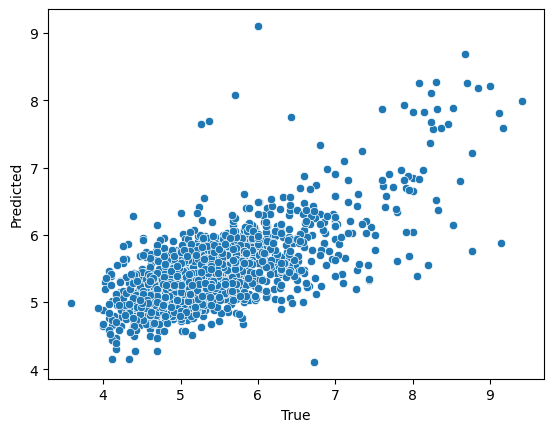

In [29]:
import seaborn as sns
pred_df = pd.DataFrame(
    {'True': y_test,
     'Predicted': y_pred
    })
sns.scatterplot(data=pred_df, x="True", y="Predicted")

Model performance can be improved using hyperparameter optimisation. We will cover this in the next exercise

### Model interpretation

We can interpret the model in a number of ways. Here we will use SHAP values to understand the contribution of each feature to the model.

To do this, we use the shap library. The TreeExplainer is fit using the trained model, and the shap values are computed for the test set. Finally, a summary plot is created. Warning: Takes some time to compute Shap values

100%|===================| 1481/1483 [03:47<00:00]       

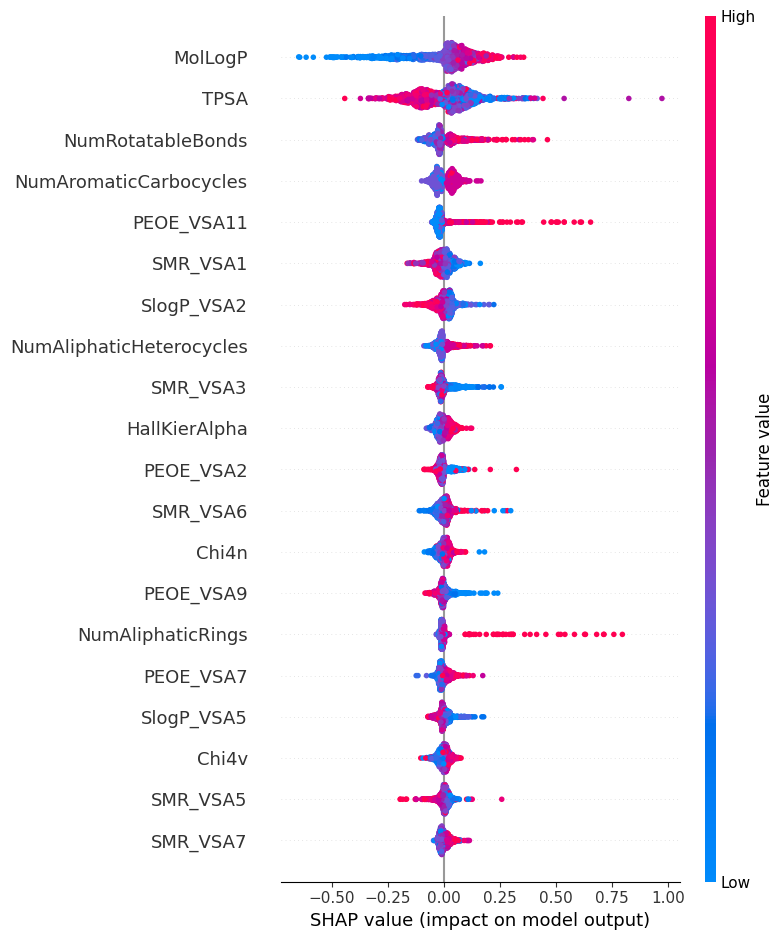

In [30]:
import shap

# explain all the predictions in the test set
explainer = shap.TreeExplainer(reg, data=X_train.sample(n=1000, random_state=42))
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

The most important features are TPSA and LogP. As the value of TPSA increases the predicted hERG pIC50 decreases, vice versa for LogP.

According to our model, to develop a new compound without hERG liability, we should ensure that the TPSA is high and the LogP is low. In reality it's more complex than that, but we have a starting point to understand why the model is making these predictions and how we can avoid developing toxic compounds in the future.

Also, please note that data curation part was not completely executed in this exercise. In reality, we don't necessarily want to combine IC50 data from different assays and protocols. Please see this excellent paper on the subject https://pubs.acs.org/doi/10.1021/acs.jcim.4c00049

Now you have succesfully trained a hERG prediction model and visualised the feature importance!

## Part 2: Classification modelling Mitochondrial Toxicity

We will now look at a classification task. We will try to predict if a compound is toxic to the mitochondrial outer membrane using chemical structure. The chemical structure is represented by bit vector of Morgan Fingerprints.

For this purpose we will follow the steps below in order

1. Load the dataset
2. Standardise smiles
3. Generate Fingerprints
4. Split data into train and test
6. Hyperparamter optimisation of Random Forest model using training data
6. Evaluate on test data

### Load the dataset

In [31]:
import rdkit
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [32]:
df = pd.read_csv('Mitotox_Dataset_Classification_Workshop.csv')
df

,InChICode_standardised,Activity
0,InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...,0.0
1,InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...,0.0
2,InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...,0.0
3,InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...,0.0
4,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...,0.0
...,...,...
6455,InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...,0.0
6456,InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...,1.0
6457,"InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...",0.0
6458,"InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...",0.0


value_counts() shows us the number of datapoints in each class of the dataset, in this case, 916 toxic compounds and 5544 non-toxic compounds.

In [33]:
df.Activity.value_counts()

,count
Activity,
0.0,5544
1.0,916


### Standardise SMILES

Below are two functions:

The first one standardised_smile_from_inchi() converts InChi code (which  is the identfier in the dataset) into SMILES (which is more commonly used to generate fingerprints)

The second function standardize(), performs various standardisation functions to return a standardised smiles.This includes deprotonation, normalisation, reionisation, neutralisation, tautomer canonicalisation etc.

The try, except combination allows for error handling, and returns "Cannot_do" if the functions fail for a particular molecule.

In [34]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import inchi
from rdkit import Chem

def standardised_smile_from_inchi(value):

    try: return Chem.MolToSmiles(inchi.MolFromInchi(value))
    except: return "Cannot_do"

def standardize(smiles):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    try:
        mol = Chem.MolFromSmiles(smiles)

        # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
        clean_mol = rdMolStandardize.Cleanup(mol)

        # if many fragments, get the "parent" (the actual mol we are interested in)
        parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

        # try to neutralize molecule
        uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
        uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

        # note that no attempt is made at reionization at this step
        # nor at ionization at some pH (rdkit has no pKa caculator)
        # the main aim to to represent all molecules from different sources
        # in a (single) standard way, for use in ML, catalogue, etc.

        te = rdMolStandardize.TautomerEnumerator() # idem
        taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)

        return  Chem.MolToSmiles(taut_uncharged_parent_clean_mol)

    except:

        return "Cannot_do"



We apply both these functions to the respective columns in the dataframe. First standardised_smile_from_inchi() converts InChICode_standardised to smiles. Then the second function standardize() converts smiles to smiles_r.

In [35]:
df["smiles"] = df["InChICode_standardised"].apply(standardised_smile_from_inchi)
df["smiles_r"] = df["smiles"].apply(standardize)
df

Streaming output truncated to the last 5000 lines.
[20:54:19] Initializing Normalizer
[20:54:19] Running Normalizer
[20:54:19] Running LargestFragmentChooser
[20:54:19] Running Uncharger
[20:54:19] Initializing MetalDisconnector
[20:54:19] Running MetalDisconnector
[20:54:19] Initializing Normalizer
[20:54:19] Running Normalizer
[20:54:19] Initializing MetalDisconnector
[20:54:19] Running MetalDisconnector
[20:54:19] Initializing Normalizer
[20:54:19] Running Normalizer
[20:54:19] Running LargestFragmentChooser
[20:54:19] Running Uncharger
[20:54:19] Initializing MetalDisconnector
[20:54:19] Running MetalDisconnector
[20:54:19] Initializing Normalizer
[20:54:19] Running Normalizer
[20:54:19] Initializing MetalDisconnector
[20:54:19] Running MetalDisconnector
[20:54:19] Initializing Normalizer
[20:54:19] Running Normalizer
[20:54:19] Running LargestFragmentChooser
[20:54:19] Running Uncharger
[20:54:19] Initializing MetalDisconnector
[20:54:19] Running MetalDisconnector
[20:54:19] Initi

,InChICode_standardised,Activity,smiles,smiles_r
0,InChI=1S/C10H19N5S/c1-6(2)11-8-13-9(12-7(3)4)1...,0.0,CSc1nc(=NC(C)C)[nH]c(=NC(C)C)[nH]1,CSc1nc(NC(C)C)nc(NC(C)C)n1
1,InChI=1S/C12H10O4/c13-11(14)7-5-9-1-2-10(4-3-9...,0.0,O=C(O)/C=C/c1ccc(/C=C/C(=O)O)cc1,O=C(O)/C=C/c1ccc(/C=C/C(=O)O)cc1
2,InChI=1S/C12H16O/c13-12-9-5-4-8-11(12)10-6-2-1...,0.0,OC1CCCCC1c1ccccc1,OC1CCCCC1c1ccccc1
3,InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-10-9-11-10/h...,0.0,CCCCCCCCC1CO1,CCCCCCCCC1CO1
4,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...,0.0,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21
...,...,...,...,...
6455,InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...,0.0,C=C(C)C1CCC(C)CC1O,C=C(C)C1CCC(C)CC1O
6456,InChI=1S/C18H16N2O3/c19-12-15(10-14-6-7-16(21)...,1.0,N#C/C(=C\c1ccc(O)c(O)c1)C(O)=NCCc1ccccc1,N#CC(=Cc1ccc(O)c(O)c1)C(=O)NCCc1ccccc1
6457,"InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...",0.0,NS(=O)(=O)C#Cc1ccccc1,NS(=O)(=O)C#Cc1ccccc1
6458,"InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...",0.0,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O


Next we remove compounds for which standardisation of smiles failed!

In [36]:
df = df[df["smiles_r"]!="Cannot_do"].reset_index(drop=True)


There maybe duplicates here, where the same standardised SMILES may have different activity. For example, sodium salt of benzoic acid and benzoic acid have the same standardised SMILES (bacause we remove salts during standardisation). In that case, we look for evidence of activity and if either compound was toxic, we mark the standardised SMILES as toxic.

In [37]:
df = df.sort_values(by="Activity", ascending=False)
df

,InChICode_standardised,Activity,smiles,smiles_r
6436,InChI=1S/C16H15F3N2O4/c1-8-12(15(22)25-3)13(14...,1.0,COC(=O)C1=C(C)NC(C)=C([N+](=O)[O-])C1c1ccccc1C...,COC(=O)C1=C(C)N=C(C)C([N+](=O)[O-])C1c1ccccc1C...
6437,InChI=1S/C10H8N2O2S/c11-5-7(10(12)15)3-6-1-2-8...,1.0,N#CC(=Cc1ccc(O)c(O)c1)C(=N)S,N#CC(=Cc1ccc(O)c(O)c1)C(N)=S
24,InChI=1S/C7H4ClNO/c8-6-1-3-7(4-2-6)9-5-10/h1-4H,1.0,O=C=Nc1ccc(Cl)cc1,O=C=Nc1ccc(Cl)cc1
40,InChI=1S/C19H17N3/c20-16-7-1-13(2-8-16)19(14-3...,1.0,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1
6449,"InChI=1S/C8H5NO4S/c10-9(11)7-2-1-6-3-4-14(12,1...",1.0,O=[N+]([O-])c1ccc2c(c1)S(=O)(=O)C=C2,O=[N+]([O-])c1ccc2c(c1)S(=O)(=O)C=C2
...,...,...,...,...
6454,InChI=1S/C9H7N/c10-8-4-7-9-5-2-1-3-6-9/h1-7H/b...,0.0,N#C/C=C/c1ccccc1,N#C/C=C/c1ccccc1
6455,InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...,0.0,C=C(C)C1CCC(C)CC1O,C=C(C)C1CCC(C)CC1O
6457,"InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...",0.0,NS(=O)(=O)C#Cc1ccccc1,NS(=O)(=O)C#Cc1ccccc1
6458,"InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...",0.0,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O


Look at the code above, we have sorted it by activity. Below, you will see, we dropped the duplicates, and among all duplicates, we kept the one that appears aboce in the dataset (which should be the toxic compound if any)

In [38]:
df = df.drop_duplicates(subset=["smiles_r"], keep="first").reset_index(drop=True)
df

,InChICode_standardised,Activity,smiles,smiles_r
0,InChI=1S/C16H15F3N2O4/c1-8-12(15(22)25-3)13(14...,1.0,COC(=O)C1=C(C)NC(C)=C([N+](=O)[O-])C1c1ccccc1C...,COC(=O)C1=C(C)N=C(C)C([N+](=O)[O-])C1c1ccccc1C...
1,InChI=1S/C10H8N2O2S/c11-5-7(10(12)15)3-6-1-2-8...,1.0,N#CC(=Cc1ccc(O)c(O)c1)C(=N)S,N#CC(=Cc1ccc(O)c(O)c1)C(N)=S
2,InChI=1S/C7H4ClNO/c8-6-1-3-7(4-2-6)9-5-10/h1-4H,1.0,O=C=Nc1ccc(Cl)cc1,O=C=Nc1ccc(Cl)cc1
3,InChI=1S/C19H17N3/c20-16-7-1-13(2-8-16)19(14-3...,1.0,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1
4,"InChI=1S/C8H5NO4S/c10-9(11)7-2-1-6-3-4-14(12,1...",1.0,O=[N+]([O-])c1ccc2c(c1)S(=O)(=O)C=C2,O=[N+]([O-])c1ccc2c(c1)S(=O)(=O)C=C2
...,...,...,...,...
6442,InChI=1S/C9H7N/c10-8-4-7-9-5-2-1-3-6-9/h1-7H/b...,0.0,N#C/C=C/c1ccccc1,N#C/C=C/c1ccccc1
6443,InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...,0.0,C=C(C)C1CCC(C)CC1O,C=C(C)C1CCC(C)CC1O
6444,"InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...",0.0,NS(=O)(=O)C#Cc1ccccc1,NS(=O)(=O)C#Cc1ccccc1
6445,"InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...",0.0,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O


We are now therefore left with 6433 compounds in this dataset.

In [39]:
df.Activity.value_counts()

,count
Activity,
0.0,5532
1.0,915


of which 915 are active (toxic) and 5518 are inactive (non-toxic)

### Generate Fingerprints

Next, we will generate Morgan fingerprints for all compounds in the dataset. So we first create Mol objeects for each smiles

In [40]:
Ser_Mol = df['smiles_r'].apply(Chem.MolFromSmiles)



The rdkit package has a function to generate Morgan Fingerprint As Bit Vector. We will first import the function

In [41]:
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

The cell below uses the function from rdkit to generate morgan fingerprints. The length of the fingerprints is 2048 bits, so each molecule has 2048 binary digits corresponding to substructures that may be present in that compound. These binary bit vectors are used as features in the model.

In [42]:
Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))

df["Morgan_fingerprint"] =Morgan_fingerprint
df

Streaming output truncated to the last 5000 lines.
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:56:06] DEPRECATION WARNING: please use MorganGenerator
[20:5

,InChICode_standardised,Activity,smiles,smiles_r,Morgan_fingerprint
0,InChI=1S/C16H15F3N2O4/c1-8-12(15(22)25-3)13(14...,1.0,COC(=O)C1=C(C)NC(C)=C([N+](=O)[O-])C1c1ccccc1C...,COC(=O)C1=C(C)N=C(C)C([N+](=O)[O-])C1c1ccccc1C...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,InChI=1S/C10H8N2O2S/c11-5-7(10(12)15)3-6-1-2-8...,1.0,N#CC(=Cc1ccc(O)c(O)c1)C(=N)S,N#CC(=Cc1ccc(O)c(O)c1)C(N)=S,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,InChI=1S/C7H4ClNO/c8-6-1-3-7(4-2-6)9-5-10/h1-4H,1.0,O=C=Nc1ccc(Cl)cc1,O=C=Nc1ccc(Cl)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,InChI=1S/C19H17N3/c20-16-7-1-13(2-8-16)19(14-3...,1.0,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"InChI=1S/C8H5NO4S/c10-9(11)7-2-1-6-3-4-14(12,1...",1.0,O=[N+]([O-])c1ccc2c(c1)S(=O)(=O)C=C2,O=[N+]([O-])c1ccc2c(c1)S(=O)(=O)C=C2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
6442,InChI=1S/C9H7N/c10-8-4-7-9-5-2-1-3-6-9/h1-7H/b...,0.0,N#C/C=C/c1ccccc1,N#C/C=C/c1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6443,InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h8...,0.0,C=C(C)C1CCC(C)CC1O,C=C(C)C1CCC(C)CC1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6444,"InChI=1S/C8H7NO2S/c9-12(10,11)7-6-8-4-2-1-3-5-...",0.0,NS(=O)(=O)C#Cc1ccccc1,NS(=O)(=O)C#Cc1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6445,"InChI=1S/C14H20O2/c1-13(2,3)9-7-12(16)10(8-11(...",0.0,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Here we create names for the features: Mfp0, Mfp1 through to Mfp2047.

In [43]:
Morgan_featurenames  = []
for x in range(0,2048):
    x = "Mfp"+str(x)
    Morgan_featurenames.append(x)

The cell below explains which variable/df is used for what in a ML model.

We are using the dataframe df, where the features which the ML model learns from is stored in the column "Morgan_fingerprint" and endpoints which is to be predicted is stored in the column "Activity".

In [44]:
data = df
features = "Morgan_fingerprint"
endpoint="Activity"

print(endpoint)

X = np.array([x for x in df['Morgan_fingerprint']])
y = data[endpoint]

Activity


Here X are the featrures and they are binary. Look at the shape of this ndarrary.

There are 6432 compounds in total and each compounds has 2048 features.

In [45]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [46]:
X.shape

(6447, 2048)

The same can be seen in y, each compound is associated to an activity.

In [47]:
y

,Activity
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
6442,0.0
6443,0.0
6444,0.0
6445,0.0


In [48]:
y.shape

(6447,)

### Split data into training and test data

Now for training a model we muyst split our dataset into train and test. This time we have a classification task. So we must ensure the _distribution_ of classes (toxic and non-toxic)remain same in both test and train.

Note the keywords here:

stratify: this means the splitting will make sure each of train and test dataset contains same proportion of both the classes.

test_size: We have selected 20% of the data to be in the test set and 75% of the data in the training dataset

random_state: Finally, this splitting will happen randomly. But to ensure this split is same for all of use, we have set a random_state. If you feel adventurous, do go ahead and change this 42 to another number. Everything will remain the same except you might find results will vary a litte.

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Our splitting is now complete. The function has split our training data (4824 compounds) and test data (1608 compounds)

In [50]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4835, 2048)
(1612, 2048)
(4835,)
(1612,)


of which the train dat contains 686 toxic compounds and test data contains 229 compounds. Can you check if this is the same ratio  to each other and the original data?

In [51]:
y_train.value_counts()

,count
Activity,
0.0,4149
1.0,686


In [52]:
y_test.value_counts()

,count
Activity,
0.0,1383
1.0,229


### Hyperparamter optimisation of Random Forest model using training data

We are going to use a Random Forest Classifier to classify mitochondiral toxicty. We will perform a 5 fold grid search cross validation to optimise the parameters of the Classifier.

We can choose between 200 and 300 trees, maximum features to be used in these trees, the minimum samples to split a node, the masimum depth of a tree.

The taining data will be split into 5 groups and 4 of these will be trained on models varying these parameters. This will be repeated 5 times and the best performing model's parameters are stored in the best_estimator_.

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42, n_jobs=-1)

param_grid = {
            "n_estimators": [200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4],
            "max_depth": [3, 5],
            "bootstrap": [True],
            'n_jobs': [-1],
            "class_weight": ["balanced"]
            }

gsh = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs=-1, verbose = 1)


In [54]:
##MODELS
print(f"Running ____________________{endpoint} MODELS")

gsh.fit(X_train, y_train)
#print(gsh.best_estimator_)

#HeldOutTest
classifier = gsh.best_estimator_

Running ____________________Activity MODELS
Fitting 5 folds for each of 16 candidates, totalling 80 fits


So this is the best model that will now be trained on the entire training data.

In [55]:
classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       max_features='log2', min_samples_split=4,
                       n_estimators=200, n_jobs=-1, random_state=42)

### Evaluate on test data

We will now evaluate our model on the test data and predict the outcome and an associated probability.

The default thrshold is 0.50

If the proba is more than 0.50, the prediction is true (toxic), else false (non-toxic)

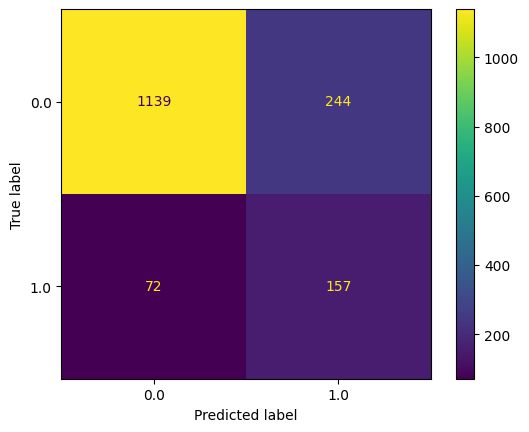

In [56]:
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.metrics import average_precision_score


y_prob= classifier.predict_proba(X_test)[:,1]
y_pred = classifier.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                           display_labels=classifier.classes_).plot()
plt.show()


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      1383
         1.0       0.39      0.69      0.50       229

    accuracy                           0.80      1612
   macro avg       0.67      0.75      0.69      1612
weighted avg       0.86      0.80      0.82      1612



This is the balanced accuracy (balanced for each class)



In [58]:
ba= balanced_accuracy_score(y_test, y_pred)
print('balanced_accuracy_score ',ba)

balanced_accuracy_score  0.7545807323488272


The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.

In [59]:
mcc=matthews_corrcoef(y_test, y_pred)
print('matthews_corrcoef ',mcc)

matthews_corrcoef  0.4111876862785954


Sensitivity and specificity mathematically describe the accuracy of a test which reports the presence or absence of a condition. Individuals for which the condition is satisfied are considered "positive" and those for which it is not are considered "negative".

Sensitivity (true positive rate) refers to the probability of a positive test, conditioned on truly being positive.

Specificity (true negative rate) refers to the probability of a negative test, conditioned on truly being negative.

In [60]:
# Sensitivity, hit rate, recall, or true positive rate
Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])

In [61]:
# Specificity or true negative rate
Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
print( 'Sensitivity', Sensitivity)
print( 'Specificity', Specificity)



Sensitivity 0.6855895196506551
Specificity 0.8235719450469993


The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)



In [62]:
f1= f1_score(y_test, y_pred, average='binary')
print('F1 Toxic', f1)

F1 Toxic 0.4984126984126984


A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.

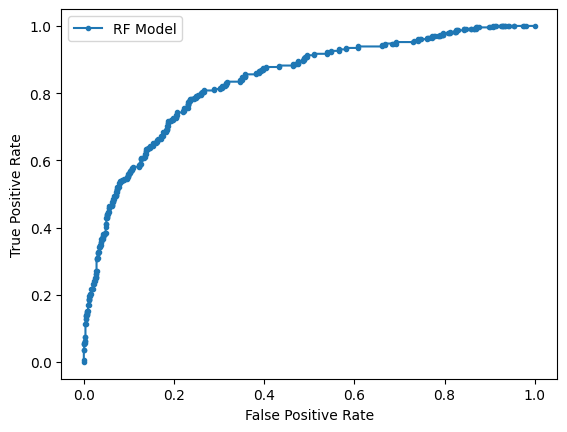

AUC-ROC  0.8349957531724905


In [63]:
# calculate roc curves
best_model_fpr, best_model_tpr, _ = roc_curve(y_test, y_prob)
plt.plot(best_model_fpr, best_model_tpr, marker='.', label='RF Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

AUC = roc_auc_score(y_test, y_prob)
print('AUC-ROC ',AUC)


In [64]:
classifier

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       max_features='log2', min_samples_split=4,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [65]:
!pip install dtreeviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.8 MB/s eta 0:00:00


So what does Random forest look like? Well its composed of various trees and this is the first one shown below:

In [66]:
import dtreeviz

random_state = 42

viz = dtreeviz.model(classifier.estimators_[0], X_train.astype(int), y_train.astype(int),
               target_name="endpoint",
               feature_names=Morgan_featurenames,
               class_names=["Non-Toxic", "Toxic"])



See how the tree splits based on certain bits and ultimately leads to nodes. Each leaf node is then assigned a class. The Random Forest works on the wisdom of the crowd, or average voting of all the trees.

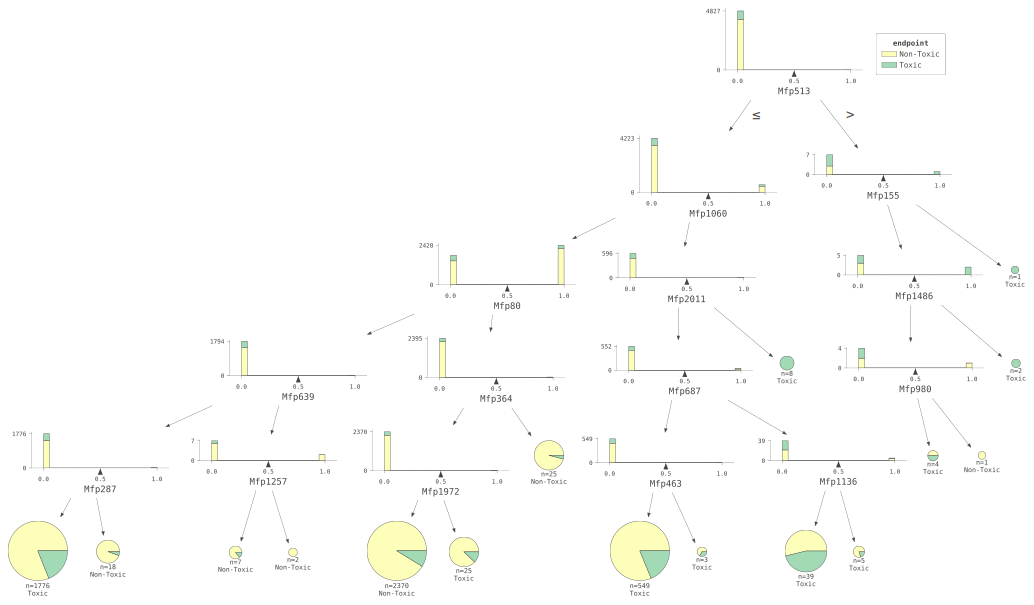

In [67]:
viz.view(fontname="monospace")

### Feature Importances

Finally, we evaluate the importance of features on the classification task. The blue bars are the feature importances of the forest.

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the meanof accumulation of the impurity decrease within each tree.

In [68]:
importances = classifier.feature_importances_
#std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
importances

array([0.        , 0.00012001, 0.00013295, ..., 0.        , 0.        ,
       0.        ])

In [69]:
forest_importances = pd.Series(importances, index=Morgan_featurenames)
forest_importances = forest_importances.sort_values(ascending=False)[:100]
forest_importances


,0
Mfp1380,0.031961
Mfp1602,0.016364
Mfp875,0.015898
Mfp1313,0.014698
Mfp202,0.013424
...,...
Mfp281,0.002244
Mfp1154,0.002240
Mfp472,0.002190
Mfp1039,0.002182


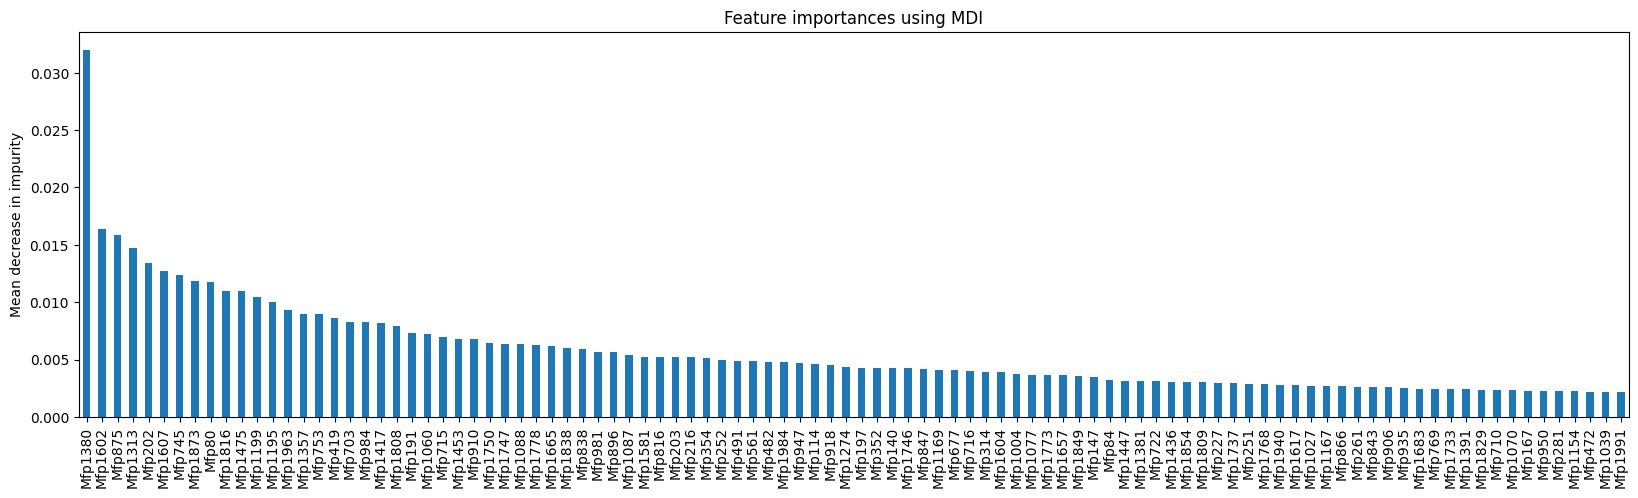

In [70]:
#We are only plotting the top 100 features here

plt.figure(figsize=(20,5), dpi=100)
forest_importances.plot.bar()
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.show()


## Now implementing the Light GBM Classifier to comapre the results

In [71]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [74]:
# Defining the parameters to search over
# This is the "grid" that the model will search through
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 10, -1], # -1 means no limit
    'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31, 40]
}

In [75]:
# Initialize the LightGBM classifier
# create a base model to be used in the grid search.
lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)

In [80]:
# Set up the Grid Search with 5-fold Cross-Validation
# cv=5 just like the randomforest model

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Number of positive: 686, number of negative: 4149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 4835, number of used features: 1346
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141882 -> initscore=-1.799745
[LightGBM] [Info] Start training from score -1.799745


GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='binary', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [5, 10, -1],
                         'n_estimators': [200, 300],
                         'num_leaves': [20, 31, 40]},
             scoring='roc_auc', verbose=1)

In [81]:
best_lgbm = grid_search.best_estimator_
print("Best parameters found by Grid Search:")
print(grid_search.best_params_)

Best parameters found by Grid Search:
{'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}


In [82]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report

In [83]:
# Make predictions on the test set
y_pred_lgbm = best_lgbm.predict(X_test)
y_pred_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [84]:
# AUC-ROC Score
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"Optimized LightGBM AUC-ROC: {roc_auc_lgbm:.4f}")

Optimized LightGBM AUC-ROC: 0.8630


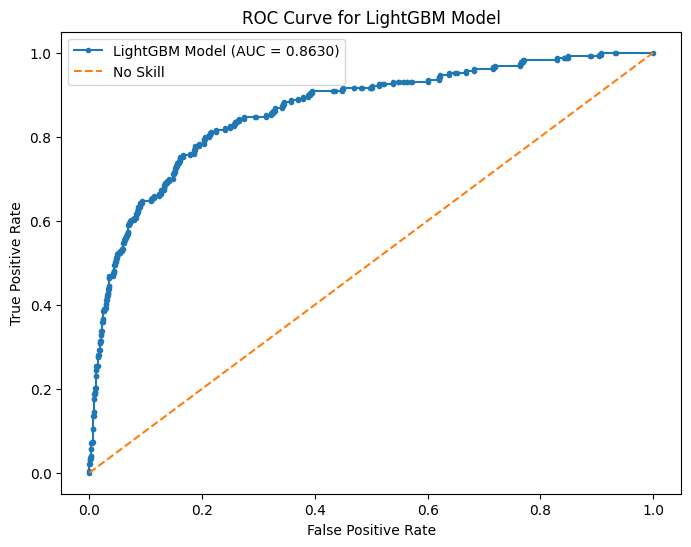

In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate the values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lgbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f'LightGBM Model (AUC = {roc_auc_lgbm:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill') # no skill is the baseline model which has a 50-50 chance of giving toxic or non toxic result

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM Model')
plt.legend()
plt.show()

In [87]:
# Balanced Accuracy
balanced_accuracy_lgbm = balanced_accuracy_score(y_test, y_pred_lgbm)
print(f"Optimized LightGBM Balanced Accuracy: {balanced_accuracy_lgbm:.4f}")


Optimized LightGBM Balanced Accuracy: 0.7054


In [88]:
#Full Classification Report
print("\n--- LightGBM Classification Report ---")
print(classification_report(y_test, y_pred_lgbm))


--- LightGBM Classification Report ---
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1383
         1.0       0.68      0.45      0.54       229

    accuracy                           0.89      1612
   macro avg       0.80      0.71      0.74      1612
weighted avg       0.88      0.89      0.88      1612



In [91]:
# Comparing randomforest classfier and light gbm classifier models
y_pred_proba_rf = classifier.predict_proba(X_test)[:, 1]
y_pred_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [92]:
from sklearn.metrics import roc_auc_score, classification_report

#Calculate AUC-ROC Scores
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

print(f"Random Forest AUC-ROC: {roc_auc_rf:.4f}")
print(f"Optimized LightGBM AUC-ROC: {roc_auc_lgbm:.4f}")

# Full Classification Reports
# classification_report needs class predictions, not probabilities
y_pred_rf = classifier.predict(X_test)
y_pred_lgbm = best_lgbm.predict(X_test)

print("\n Random Forest Classification Report ")
print(classification_report(y_test, y_pred_rf))

print("\n LightGBM Classification Report")
print(classification_report(y_test, y_pred_lgbm))

Random Forest AUC-ROC: 0.8350
Optimized LightGBM AUC-ROC: 0.8630

 Random Forest Classification Report 
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      1383
         1.0       0.39      0.69      0.50       229

    accuracy                           0.80      1612
   macro avg       0.67      0.75      0.69      1612
weighted avg       0.86      0.80      0.82      1612


 LightGBM Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1383
         1.0       0.68      0.45      0.54       229

    accuracy                           0.89      1612
   macro avg       0.80      0.71      0.74      1612
weighted avg       0.88      0.89      0.88      1612



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


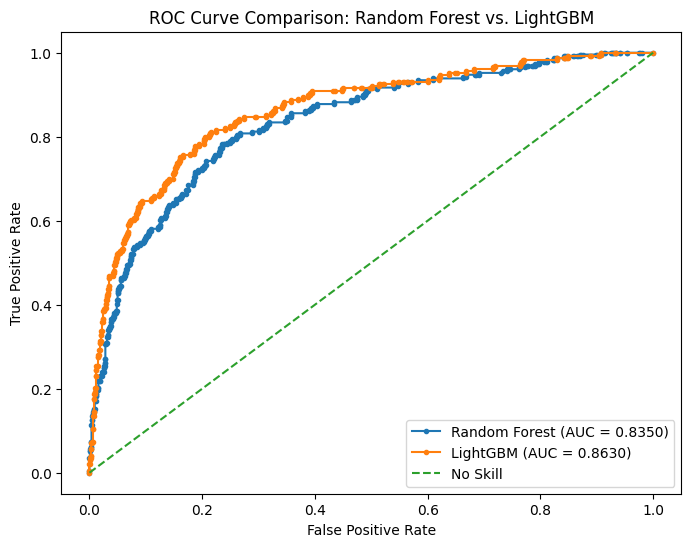

In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate ROC curve values for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)

#  Create the plot
plt.figure(figsize=(8, 6))

# Plot the Random Forest curve
plt.plot(fpr_rf, tpr_rf, marker='.', label=f'Random Forest (AUC = {roc_auc_rf:.4f})')

# Plot the LightGBM curve
plt.plot(fpr_lgbm, tpr_lgbm, marker='.', label=f'LightGBM (AUC = {roc_auc_lgbm:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Random Forest vs. LightGBM')
plt.legend()
plt.show()